In [ ]:
#python version check/Python 3.11.7
! python --version

In [ ]:
pip install duckdb redis sentence-transformers

In [56]:
#importing libraries
import random
import numpy as np
import pandas as pd
import duckdb
import redis
from sentence_transformers import SentenceTransformer
import pytest
from faker import Faker
import time
import string
import pickle
import base64
from memory_profiler import memory_usage
import memory_profiler
from concurrent.futures import ThreadPoolExecutor
#from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm 
from numpy import dot
from numpy.linalg import norm
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import pickle

In [60]:
import warnings

In [62]:
warnings.filterwarnings('ignore')

In [12]:
model = SentenceTransformer('all-MiniLM-L6-v2')
# "all-MiniLM-L6-v2" is a pre-trained model for (Selected because it is good for general usage and fast)

In [24]:
def generate_embeddings_in_batches(data, batch_size=100, column_name="Description"):
#batch_size=100 is a balanced default.
    all_embeddings = []
    
    # Loop through the dataset in batches with a progress bar
    for i in tqdm(range(0, len(data), batch_size), desc="Processing batches"):
        batch = data.iloc[i:i+batch_size]  
        descriptions = batch[column_name].tolist()  
        
         # Generate embeddings for the batch
        batch_embeddings = model.encode(descriptions, show_progress_bar=False)
        all_embeddings.extend(batch_embeddings)
    
    data['Embedding'] = [embedding.tolist() for embedding in all_embeddings]
    
    return data


In [26]:
# Creating Product Description
def generate_description():
    adjectives = ["Amazing", "Comprehensive", "Detailed", "Unique", "Classic"]
    genres = ["fiction", "non-fiction", "science", "history", "fantasy"]
    audience = ["adults", "kids", "teens", "everyone"]
    return f"{random.choice(adjectives)} {random.choice(genres)} book for {random.choice(audience)}."

In [28]:
# Creating Product Name
def generate_product_name():
    adjectives = ["Brilliant", "Mysterious", "Wonderful", "Enigmatic", "Classic", "Charming", "Unforgettable"]
    nouns = ["Journey", "Adventure", "Tale", "Story", "Chronicles", "Saga", "Quest"]
    conjunctions = ["of", "and", "in", "for"]
    name = f"{random.choice(adjectives)} {random.choice(nouns)} {random.choice(conjunctions)} {random.choice(adjectives)} {random.choice(nouns)}"
    return name

In [32]:
def generate_dataset(num_records=100000):
    data = []
    for i in range(num_records):
        product_id = f"{i+1:06d}"  
        product_name = generate_product_name() 
        category = "Books" # Only selected Books category. Actually, this is only a column for the category, which is not necessary. I would not drop from "df".
        price = random.randint(5, 200)  
        description = generate_description() 
        
        data.append({
            "Product_ID": product_id,
            "Product_Name": product_name,
            "Category": category,
            "Price": price,
            "Description": description
        })
    
    return pd.DataFrame(data)

In [34]:
# Generating Dataset (100.000 rows)
df = generate_dataset(num_records=100000)

In [36]:
#Generating Embeddings with batch
df_with_embeddings = generate_embeddings_in_batches(df, batch_size=500)

# Save the dataset as CSV, if necessary.
#df_with_embeddings.to_csv("products_with_embeddings.csv", index=False)

Processing batches: 100%|██████████| 200/200 [10:27<00:00,  3.14s/it]


In [38]:
df=df_with_embeddings.copy()

In [40]:
df.head()

,Product_ID,Product_Name,Category,Price,Description,Embedding
0,000001,Wonderful Tale and Unforgettable Story,Books,127,Classic fiction book for everyone.,"[-0.008416999131441116, 0.03524068370461464, 0..."
1,000002,Unforgettable Journey for Mysterious Saga,Books,166,Comprehensive history book for adults.,"[-0.007291584275662899, 0.02718379721045494, 0..."
2,000003,Mysterious Story of Classic Adventure,Books,171,Detailed fantasy book for everyone.,"[-0.016391141340136528, 0.02698318101465702, 0..."
3,000004,Wonderful Quest for Unforgettable Saga,Books,7,Amazing fantasy book for adults.,"[0.025390397757291794, 0.027749400585889816, 0..."
4,000005,Wonderful Journey for Brilliant Chronicles,Books,150,Comprehensive non-fiction book for kids.,"[-0.0216752290725708, -0.017193501815199852, 0..."


In [44]:
df.shape

(100000, 6)

In [ ]:
# Creting table with DuckDB. Table used for filtering. 

In [46]:
# DuckDB Connection
conn = duckdb.connect()

In [48]:
# For storing Vectors table created.
conn.execute("""
    CREATE TABLE Products_V1 (
        Product_ID INTEGER PRIMARY KEY,
        Product_Name VARCHAR,
        Category VARCHAR,
        Price FLOAT,
        Description TEXT,
        product_vector BLOB 
    )
""")

In [50]:
#adding each vector to the DB.
for index, row in df.iterrows():
    vector_blob = pickle.dumps(row['Embedding']) 
    conn.execute("""
        INSERT INTO Products_V1 (Product_ID, Product_Name, Category, Price, Description, product_vector)
        VALUES (?, ?, ?, ?, ?, ?)
    """, (row['Product_ID'], row['Product_Name'], row['Category'], row['Price'], row['Description'], vector_blob))

In [52]:
# "Cosine Similarity" function.
def cosine_similarity(v1, v2):
    return dot(v1, v2) / (norm(v1) * norm(v2))

In [57]:
# Selecting product data from DB.
results = conn.execute("SELECT Product_ID, Product_Name, Price, Description, product_vector FROM Products_V1").fetchall()
similarities=[]

query_vector = np.random.rand(384)

for row in results:
    product_vector = np.array(pickle.loads(row[4]))  # (5.column: product_vector)
    
    
    query_vector_2d = query_vector.reshape(1, -1)
    product_vector_2d = product_vector.reshape(1, -1)
    
    # Using "Cosine Similarity" function: from sklearn.metrics.pairwise import cosine_similarity
    similarity = cosine_similarity(query_vector_2d, product_vector_2d)
    
    # Adding all columns and similarity score.
    similarities.append({
        "Product_ID": row[0],       
        "Product_Name": row[1],     
        "Product_Description": row[2], 
        "Product_Price": row[3],        
        "Similarity": similarity[0][0]  
    })



FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [ ]:
#warnings.filterwarnings("ignore", message="Failed to load model class 'FloatProgressModel'")

In [64]:
# Ordering with similarty scores(desc).
sorted_similarities = sorted(similarities, key=lambda x: x["Similarity"], reverse=True)

# Top 10 Similar Products
top_10_similar_products = sorted_similarities[:10]

# Print Top 10 Similar Products
for product in top_10_similar_products:
    print(product)

{'Product_ID': 13676, 'Product_Name': 'Unforgettable Tale and Wonderful Adventure', 'Product_Description': 178.0, 'Product_Price': 'Classic fantasy book for kids.', 'Similarity': 0.04406056519493465}
{'Product_ID': 43700, 'Product_Name': 'Brilliant Chronicles and Unforgettable Saga', 'Product_Description': 7.0, 'Product_Price': 'Classic fantasy book for kids.', 'Similarity': 0.04406056519493465}
{'Product_ID': 88721, 'Product_Name': 'Classic Saga for Wonderful Story', 'Product_Description': 53.0, 'Product_Price': 'Classic fantasy book for kids.', 'Similarity': 0.04406056519493465}
{'Product_ID': 37, 'Product_Name': 'Wonderful Adventure of Charming Quest', 'Product_Description': 23.0, 'Product_Price': 'Classic fantasy book for kids.', 'Similarity': 0.04406055211086256}
{'Product_ID': 68, 'Product_Name': 'Enigmatic Adventure and Wonderful Adventure', 'Product_Description': 94.0, 'Product_Price': 'Classic fantasy book for kids.', 'Similarity': 0.04406055211086256}
{'Product_ID': 211, 'Pro

In [66]:
# Checking table 
conn.execute("DESCRIBE Products_V1").fetchall()

[('Product_ID', 'INTEGER', 'NO', 'PRI', None, None),
 ('Product_Name', 'VARCHAR', 'YES', None, None, None),
 ('Category', 'VARCHAR', 'YES', None, None, None),
 ('Price', 'FLOAT', 'YES', None, None, None),
 ('Description', 'VARCHAR', 'YES', None, None, None),
 ('product_vector', 'BLOB', 'YES', None, None, None)]

In [ ]:
# manual process for adding indexes and deleting. Before converting to the function all the things.

#conn = duckdb.connect('ProductsV1.db')  

# creating index
conn.execute("CREATE INDEX idx_Product_Name ON Products1(Product_Name)")
conn.execute("CREATE INDEX idx_Price ON Products1(Price)")
conn.execute("CREATE INDEX idx_Description ON Products1(Description)")

# index control
indexes = conn.execute("SHOW pg_indexes;").fetchall()

print(indexes)

conn.execute("DROP INDEX IF EXISTS idx_Product_Name")
conn.execute("DROP INDEX IF EXISTS idx_Price")
conn.execute("DROP INDEX IF EXISTS idx_Description")


# closing the connection.
#conn.close()

In [86]:
# Checking table 
conn.execute("DESCRIBE Products_V1").fetchall()

[('Product_ID', 'INTEGER', 'NO', 'PRI', None, None),
 ('Product_Name', 'VARCHAR', 'YES', None, None, None),
 ('Category', 'VARCHAR', 'YES', None, None, None),
 ('Price', 'FLOAT', 'YES', None, None, None),
 ('Description', 'VARCHAR', 'YES', None, None, None),
 ('product_vector', 'BLOB', 'YES', None, None, None)]

In [98]:
# Function for testing performance
def benchmark_query_latency_and_memory(conn, query, query_vector):
    # Memory usage before query
    start_mem = memory_profiler.memory_usage()[0]
    
    start_time = time.time()
    
    results = conn.execute(query).fetchall()
    
    end_time = time.time()
    
    # Memory usage after query
    end_mem = memory_profiler.memory_usage()[0]
    
    # Cosine similarity 
    similarities = []
    for row in results:
        product_vector = np.array(pickle.loads(row[4]))  # (column 5: product_vector)
        similarity = cosine_similarity(query_vector, product_vector)
        similarities.append({
            "Product_ID": row[0],
            "Product_Name": row[1],
            "Price": row[2],
            "Description": row[3],
            "Similarity": similarity
        })
    
    query_latency = end_time - start_time
    memory_usage = end_mem - start_mem

    return query_latency, memory_usage, similarities

# time spend for indexing
def benchmark_index_creation(conn):
    start_time = time.time()
    

    conn.execute("CREATE INDEX idx_Product_Name ON Products_V1(Product_Name)")
    conn.execute("CREATE INDEX idx_Price ON Products_V1(Price)")
    conn.execute("CREATE INDEX idx_Description ON Products_V1(Description)")
    
    end_time = time.time()
    index_build_time = end_time - start_time
    
    return index_build_time


In [102]:
def run_performance_tests():
  
    conn = duckdb.connect('Products_V1.db')  

    conn.execute("DROP INDEX IF EXISTS idx_Product_Name")
    conn.execute("DROP INDEX IF EXISTS idx_Price")
    conn.execute("DROP INDEX IF EXISTS idx_Description")
    
    # for calculate Cosine similarity
    query = "SELECT Product_ID, Product_Name, Price, Description, product_vector FROM Products_V1 LIMIT 100"
    query_vector = np.random.rand(384)  


    print("=== Before Index Creation ===")
    before_index_query_latency, before_index_memory_usage, before_index_similarities = benchmark_query_latency_and_memory(conn, query, query_vector)
    print(f"Query Latency: {before_index_query_latency:.4f} seconds")
    print(f"Memory Usage: {before_index_memory_usage:.4f} MB")

    # ** index Build Time Test**
    index_build_time = benchmark_index_creation(conn)
    print(f"Index Build Time: {index_build_time:.4f} seconds")
    
    
    print("\n=== After Index Creation ===")
    after_index_query_latency, after_index_memory_usage, after_index_similarities = benchmark_query_latency_and_memory(conn, query, query_vector)
    print(f"Query Latency: {after_index_query_latency:.4f} seconds")
    print(f"Memory Usage: {after_index_memory_usage:.4f} MB")
    

    print("\n=== Performance Comparison ===")
    print(f"Before Index Query Latency: {before_index_query_latency:.4f} seconds")
    print(f"After Index Query Latency: {after_index_query_latency:.4f} seconds")
    print(f"Improvement in Query Latency: {before_index_query_latency - after_index_query_latency:.4f} seconds")
    
    print(f"Before Index Memory Usage: {before_index_memory_usage:.4f} MB")
    print(f"After Index Memory Usage: {after_index_memory_usage:.4f} MB")
    print(f"Improvement in Memory Usage: {before_index_memory_usage - after_index_memory_usage:.4f} MB")
      
    conn.close()

In [88]:
conn

In [104]:
# call the function
run_performance_tests()

=== Before Index Creation ===
Query Latency: 0.0229 seconds
Memory Usage: 0.6602 MB
Index Build Time: 0.0535 seconds

=== After Index Creation ===
Query Latency: 0.0076 seconds
Memory Usage: 0.1758 MB

=== Performance Comparison ===
Before Index Query Latency: 0.0229 seconds
After Index Query Latency: 0.0076 seconds
Improvement in Query Latency: 0.0153 seconds
Before Index Memory Usage: 0.6602 MB
After Index Memory Usage: 0.1758 MB
Improvement in Memory Usage: 0.4844 MB


In [56]:
### *** Redis ***

In [112]:
# Redis Connection
redis_conn = redis.StrictRedis(host='localhost', port=6379, db=0)
#Connected with Docker also.

In [108]:
df.head()

,Product_ID,Product_Name,Category,Price,Description,Embedding
0,000001,Wonderful Tale and Unforgettable Story,Books,127,Classic fiction book for everyone.,"[-0.008416999131441116, 0.03524068370461464, 0..."
1,000002,Unforgettable Journey for Mysterious Saga,Books,166,Comprehensive history book for adults.,"[-0.007291584275662899, 0.02718379721045494, 0..."
2,000003,Mysterious Story of Classic Adventure,Books,171,Detailed fantasy book for everyone.,"[-0.016391141340136528, 0.02698318101465702, 0..."
3,000004,Wonderful Quest for Unforgettable Saga,Books,7,Amazing fantasy book for adults.,"[0.025390397757291794, 0.027749400585889816, 0..."
4,000005,Wonderful Journey for Brilliant Chronicles,Books,150,Comprehensive non-fiction book for kids.,"[-0.0216752290725708, -0.017193501815199852, 0..."


In [114]:
redis_conn.flushall()
# for connection control

True

In [116]:
np.random.seed(0)  # for random vectors

# adding df to Redis
for index, row in df.iterrows():
    Product_ID = row['Product_ID']
    Product_Name = row['Product_Name']
    Category = row['Category']
    Price = row['Price']
    Description = row['Description']
    vector = row['Embedding']

    # Encoding vector in base64 format. 
    vector_base64 = base64.b64encode(pickle.dumps(vector)).decode('utf-8')

    # Adding data in hash format.
    redis_conn.hset(f"product:{Product_ID}", "Product_Name", Product_Name)
    redis_conn.hset(f"product:{Product_ID}", "Category", Category)
    redis_conn.hset(f"product:{Product_ID}", "Price", Price)
    redis_conn.hset(f"product:{Product_ID}", "Description", Description)
    redis_conn.hset(f"product:{Product_ID}", "Product_vector", vector_base64)

print("Data added.")

Data added.


In [138]:
#redis_conn = redis.StrictRedis(host='localhost', port=6379, db=0)

query_vector = np.random.rand(384).reshape(1, -1)

# get all info from Redis
product_ids = redis_conn.keys("product:*")
similarities = []

for product_id in product_ids:
    
    product_info = redis_conn.hgetall(product_id)

    
    product_vector_base64 = product_info.get(b'Product_vector')
    if product_vector_base64:
        
        product_vector = pickle.loads(base64.b64decode(product_vector_base64))

        # İif vector type is list we can convert it to the numpy array.
        if isinstance(product_vector, list):
            product_vector = np.array(product_vector)
        
        product_vector_2d = product_vector.reshape(1, -1)
        
        # Cosine Similarity
        similarity = cosine_similarity(query_vector, product_vector_2d)[0][0]

        
        product_id_value = product_info.get(b'Product_ID')
        product_name = product_info.get(b'Product_Name')
        product_description = product_info.get(b'Product_Description')
        product_price = product_info.get(b'Product_Price')

        # "Unknown" for null keys.
        similarities.append({
            "Product_ID": product_id_value.decode('utf-8') if product_id_value else "Unknown",
            "Product_Name": product_name.decode('utf-8') if product_name else "Unknown",
            "Product_Description": product_description.decode('utf-8') if product_description else "No Description",
            "Product_Price": float(product_price.decode('utf-8')) if product_price else 0.0,
            "Similarity": similarity
        })


sorted_similarities = sorted(similarities, key=lambda x: x["Similarity"], reverse=True)


top_10_similar_products = sorted_similarities[:10]


for product in top_10_similar_products:
    print(product)


{'Product_ID': 'Unknown', 'Product_Name': 'Enigmatic Quest for Unforgettable Chronicles', 'Product_Description': 'No Description', 'Product_Price': 0.0, 'Similarity': 0.0879556342527879}
{'Product_ID': 'Unknown', 'Product_Name': 'Enigmatic Journey in Charming Journey', 'Product_Description': 'No Description', 'Product_Price': 0.0, 'Similarity': 0.0879556342527879}
{'Product_ID': 'Unknown', 'Product_Name': 'Unforgettable Story in Charming Chronicles', 'Product_Description': 'No Description', 'Product_Price': 0.0, 'Similarity': 0.0879556342527879}
{'Product_ID': 'Unknown', 'Product_Name': 'Brilliant Tale in Enigmatic Saga', 'Product_Description': 'No Description', 'Product_Price': 0.0, 'Similarity': 0.0879556342527879}
{'Product_ID': 'Unknown', 'Product_Name': 'Unforgettable Saga for Classic Saga', 'Product_Description': 'No Description', 'Product_Price': 0.0, 'Similarity': 0.0879556342527879}
{'Product_ID': 'Unknown', 'Product_Name': 'Charming Tale and Brilliant Chronicles', 'Product_De

In [ ]:
#Redis Query Optimization

In [92]:

def benchmark_query_latency_and_memory(redis_conn, query_vector):

    start_mem = memory_profiler.memory_usage()[0]
    
    start_time = time.time()
    
   
    product_ids = redis_conn.keys("product:*")
    
    similarities_Redis = []
    
    # Her ürünle cosine benzerliği 
    for product_id in product_ids:
       
        product_info = redis_conn.hgetall(product_id)
        product_vector_base64 = product_info.get(b'product_vector')
        

        if product_vector_base64:
            product_vector = pickle.loads(base64.b64decode(product_vector_base64))
            
            
            similarity = cosine_similarity(query_vector.reshape(1, -1), product_vector.reshape(1, -1))[0][0]
            similarities_Redis.append((product_id.decode('utf-8'), similarity))
    
    end_time = time.time()
    
    
    end_mem = memory_profiler.memory_usage()[0]
    
    query_latency = end_time - start_time
    memory_usage = end_mem - start_mem
    
    return query_latency, memory_usage, similarities_Redis


def run_performance_tests():
 
    query_vector = np.random.rand(384)  
    
    # **İndeks olmadan önceki test**
    print("=== Before Index Creation ===")
    before_index_query_latency, before_index_memory_usage, before_index_similarities = benchmark_query_latency_and_memory(redis_conn, query_vector)
    print(f"Query Latency: {before_index_query_latency:.4f} seconds")
    print(f"Memory Usage: {before_index_memory_usage:.4f} MB")
    

    
    # **İndeks sonrası test** (Veritabanındaki verileri güncelledikten sonra tekrar test edebiliriz)
    print("\n=== After Index Creation ===")
    after_index_query_latency, after_index_memory_usage, after_index_similarities = benchmark_query_latency_and_memory(redis_conn, query_vector)
    print(f"Query Latency: {after_index_query_latency:.4f} seconds")
    print(f"Memory Usage: {after_index_memory_usage:.4f} MB")
    
    # Sonuçları karşılaştırma
    print("\n=== Performance Comparison ===")
    print(f"Before Index Query Latency: {before_index_query_latency:.4f} seconds")
    print(f"After Index Query Latency: {after_index_query_latency:.4f} seconds")
    print(f"Improvement in Query Latency: {before_index_query_latency - after_index_query_latency:.4f} seconds")
    
    print(f"Before Index Memory Usage: {before_index_memory_usage:.4f} MB")
    print(f"After Index Memory Usage: {after_index_memory_usage:.4f} MB")
    print(f"Improvement in Memory Usage: {before_index_memory_usage - after_index_memory_usage:.4f} MB")

# Testi çalıştırma
run_performance_tests()


=== Before Index Creation ===
Query Latency: 110.8202 seconds
Memory Usage: 11.6953 MB

=== After Index Creation ===
Query Latency: 103.6501 seconds
Memory Usage: 4.8008 MB

=== Performance Comparison ===
Before Index Query Latency: 110.8202 seconds
After Index Query Latency: 103.6501 seconds
Improvement in Query Latency: 7.1701 seconds
Before Index Memory Usage: 11.6953 MB
After Index Memory Usage: 4.8008 MB
Improvement in Memory Usage: 6.8945 MB


In [ ]:
#####  - Test scenarios:   #####
#   Faceted search with varying numbers of filters
#   Combined vector and faceted search
#   Running each test at least 100 times to get statistically significant results

In [ ]:
###  duckDB   ###

In [140]:
conn = duckdb.connect('Products_V1.db') 

In [148]:
def faceted_search_test(filters, num_runs=100):
    query = "SELECT Product_ID, Product_Name, Price FROM Products_V1 WHERE 1=1"
    
    # Adding filter
    for filter_key, filter_value in filters.items():
        query += f" AND {filter_key} = '{filter_value}'"

    # running test for 100 times
    start_time = time.time()
    for _ in range(num_runs):
        conn.execute(query)
    end_time = time.time()

    duration = (end_time - start_time) / num_runs  # Ortalama süre
    return duration


In [150]:
# test with one filter
filters_1 = {"Category": "Books"}
avg_time_1_filter = faceted_search_test(filters_1)
print(f"Avg Time for 1 filter: {avg_time_1_filter} seconds")

# test with two filters
filters_2 = {"Category": "Books", "Price": "50"}
avg_time_2_filters = faceted_search_test(filters_2)
print(f"Avg Time for 2 filters: {avg_time_2_filters} seconds")

# test with three filters
filters_3 = {"Category": "Books", "Price": "50", "Description": "Description_1"}
avg_time_3_filters = faceted_search_test(filters_3)
print(f"Avg Time for 3 filters: {avg_time_3_filters} seconds")


Avg Time for 1 filter: 0.002622687816619873 seconds
Avg Time for 2 filters: 0.0007976007461547852 seconds
Avg Time for 3 filters: 0.0006210565567016602 seconds


In [152]:
def combined_vector_and_faceted_search(query_vector, filters, num_runs=100):
    query = "SELECT Product_ID, Product_Name, Price, product_vector FROM Products_V1 WHERE 1=1"
    
   
    for filter_key, filter_value in filters.items():
        query += f" AND {filter_key} = '{filter_value}'"

   
    start_time = time.time()
    for _ in range(num_runs):
        results = conn.execute(query).fetchall()
        
        
        similarities = []
        for row in results:
            product_vector = np.frombuffer(row[3], dtype=np.float32).reshape(1, -1)
            similarity = cosine_similarity(query_vector, product_vector)[0][0]
            similarities.append((row[0], similarity))
        
        similarities.sort(key=lambda x: x[1], reverse=True)
    end_time = time.time()

    duration = (end_time - start_time) / num_runs  
    return duration


In [154]:
query_vector = np.random.rand(384).reshape(1, -1)

#testing with one filter and vector search
filters_1 = {"Category": "Category_A"}
avg_time_combined_1 = combined_vector_and_faceted_search(query_vector, filters_1)
print(f"Avg Time for 1 filter with vector: {avg_time_combined_1} seconds")

#testing with two filters and vector search
filters_2 = {"Category": "Category_A", "Price": "50"}
avg_time_combined_2 = combined_vector_and_faceted_search(query_vector, filters_2)
print(f"Avg Time for 2 filters with vector: {avg_time_combined_2} seconds")


Avg Time for 1 filter with vector: 0.002708101272583008 seconds
Avg Time for 2 filters with vector: 0.0006314802169799804 seconds


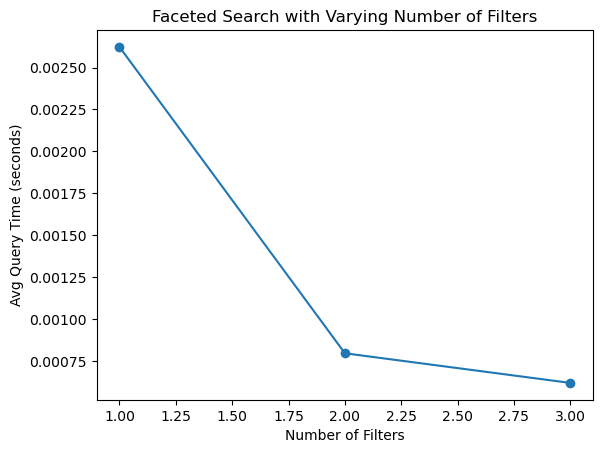

In [156]:
filters = [1, 2, 3]
times = [avg_time_1_filter, avg_time_2_filters, avg_time_3_filters]

plt.plot(filters, times, marker='o')
plt.title("Faceted Search with Varying Number of Filters")
plt.xlabel("Number of Filters")
plt.ylabel("Avg Query Time (seconds)")
plt.show()


In [158]:
def statistical_analysis(times):
    print(f"Mean: {np.mean(times)}")
    print(f"Standard Deviation: {np.std(times)}")
    print(f"Median: {np.median(times)}")

times = [avg_time_1_filter, avg_time_2_filters, avg_time_3_filters]
statistical_analysis(times)


Mean: 0.0013471150398254395
Standard Deviation: 0.0009048411994678815
Median: 0.0007976007461547852


In [ ]:
### Redis ###

In [175]:
def faceted_search_test(filters, num_runs=100):

    product_keys = redis_conn.keys("product:*") 
    
   
    filtered_product_ids = []

    start_time = time.time()
    
    for _ in range(num_runs):

        for product_key in product_keys:
            product_info = redis_conn.hgetall(product_key)

            
            if not product_info:
                continue
            

            match = True
            for filter_key, filter_value in filters.items():
                if product_info.get(filter_key.encode()) != filter_value.encode():
                    match = False
                    break 
                

            if match and b'Product_ID' in product_info:
                product_id = product_info.get(b'Product_ID')
                if product_id:  
                    filtered_product_ids.append(product_id.decode('utf-8'))
    
    end_time = time.time()
    duration = (end_time - start_time) / num_runs 
    return duration



In [177]:

filters_1 = {"Category": "Books"}
avg_time_1_filter = faceted_search_test(filters_1)
print(f"Avg Time for 1 filter: {avg_time_1_filter} seconds")


filters_2 = {"Category": "Books", "Price": "50"}
avg_time_2_filters = faceted_search_test(filters_2)
print(f"Avg Time for 2 filters: {avg_time_2_filters} seconds")

filters_3 = {"Category": "Books", "Price": "50", "Description": "Description_1"}
avg_time_3_filters = faceted_search_test(filters_3)
print(f"Avg Time for 3 filters: {avg_time_3_filters} seconds")


KeyboardInterrupt



In [ ]:

def statistical_analysis(times):
    print(f"Mean: {np.mean(times)}")
    print(f"Standard Deviation: {np.std(times)}")
    print(f"Median: {np.median(times)}")


times = [avg_time_1_filter, avg_time_2_filters, avg_time_3_filters]


statistical_analysis(times)
